# SEQ2SEQ 모델 기반 ChatBot 모델 학습

In [1]:
import tensorflow as tf
import numpy as np
import os
import json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 랜덤 시드 고정

In [2]:
SEED = 1234
tf.random.set_seed(SEED)

# 학습 데이터 

In [3]:
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

index_inputs = np.load(open(TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_CONFIGS, 'r'))

#  하이퍼 파라미터 

In [197]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

word2idx = prepro_configs['word2idx']
idx2word = prepro_configs['idx2word']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

# 모델

## 인코더

In [199]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, 
                                       return_sequences=True, return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))
        

## 어텐션

In [200]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)  # (units, 1)
        
        # score: (batch_size, max_sequence, 1)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))
        
        # attention_weights: (batch_size, max_sequence, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector: (batch_size, units)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

## 디코더

In [201]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim          
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, 
                                       return_sequences=True, return_state=True,
                                       recurrent_initializer='glorot_uniform')        
        
        self.fc = tf.keras.layers.Dense(self.vocab_size)
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        
        # x: (batch_size,)
        # hidden : (batch_size, units)
        # enc_output : (batch_size, max_sequence, units)
                
        # context_vector: (batch_size, units)   
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        x = self.embedding(x) # (batch_size, embedding_dim)
            
        # concat of [batch_size, units] and [batch_size, embedding_dim]
        #  ==> [batch_size, units+embedding_dim]
        #x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        x = tf.concat([context_vector, x], axis=1)
        
        # x: [batch_size, 1, units+embedding_dim] for GRU input
        x = tf.expand_dims(x, axis=1)
        
        # output: (batch_size, 1, units)
        # state : (batch_size, units)
        output, state = self.gru(x)
        
        # predictions: (batch_size, vocab_size)
        predictions = self.fc(tf.squeeze(output, axis=1)) 
        
        return predictions, state, attention_weights
    

## 시퀀스 투 시퀀스 모델

In [241]:
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_size, end_token_idx=2):    
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_size) 
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_size) 
        
    def call(self,x):  # when training
        # inp: (batch_size, max_sequence)
        # tar: (batch_size, max_sequence)
        inp, tar = x
   
        # enc_hidden : (batch_size, units)
        # enc_output : (batch_size, max_sequencee, units)
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        
        predict_tokens = list()
        for t in range(0, tar.shape[1]):
            
            # dec_input: (batch_size, )
            dec_input = tf.dtypes.cast(tar[:, t], tf.float32)
            
            # prediction: (batch_size, vocab_size)
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(predictions)
        
        # logits: (batch_size, max_len, vocab_size)
        logits = tf.stack(predict_tokens, axis=1) 

        return logits
    
    def inference(self, x):
        inp = x
        
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)
        
        # (batch_size=1, )
        dec_input = tf.expand_dims([word2idx[std_index]],0)   # <SOS>
        dec_hidden = enc_hidden
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])  # choose single word
            
            if predict_token == self.end_token_idx:  # <END>
                break
                
            predict_tokens.append(predict_token)
            
            # (batch_size=1, )
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)
            
        return prediction_tokens
        
        
    
    

In [242]:

# <PAD> 부분을 reduce_sum에 포함 안시키기 위해 loss 계산시에는 reduce를 안하고
# 0부분을 mask out한 후에 reduce 한다.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss(y_true, y_pred):
    # y_true : (batch_size, )
    # y_pred : (batch_size, nclass)
    
    mask = tf.logical_not(tf.equal(y_true, 0))
    loss_ = loss_object(y_true, y_pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)


train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
def accuracy(y_true, y_pred):
    # y_true : (batch_size, )
    # y_pred : (batch_size, nclass)
    
    mask = tf.logical_not(tf.equal(y_true, 0))    
    mask = tf.expand_dims(tf.cast(mask, dtype=y_pred.dtype), axis=-1) # (batch_size, 1)
    y_pred *= mask
    acc = train_accuracy(y_true, y_pred)
    
    return tf.reduce_mean(acc)
    

In [243]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, word2idx[end_index])
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])
#model.summary()

# 학습 진행 

In [244]:
DATA_OUT_PATH = './train_output/'
PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
        os.makedirs(os.path.join(PATH))
        
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

EPOCH = 30 # 30
MAX_DATA = 100
history = model.fit([index_inputs[:MAX_DATA], index_outputs[:MAX_DATA]], index_targets[:MAX_DATA],
                    batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])


Epoch 1/30
45/45 [==============================] - ETA: 0s - loss: 1.4822 - accuracy: 0.8271
Epoch 00001: val_accuracy improved from -inf to 0.84873, saving model to ./train_output/seq2seq_kor/weights.h5
45/45 [==============================] - 8s 183ms/step - loss: 1.4822 - accuracy: 0.8271 - val_loss: 1.3456 - val_accuracy: 0.8487
Epoch 2/30
45/45 [==============================] - ETA: 0s - loss: 1.0151 - accuracy: 0.8463
Epoch 00002: val_accuracy improved from 0.84873 to 0.84897, saving model to ./train_output/seq2seq_kor/weights.h5
45/45 [==============================] - 6s 123ms/step - loss: 1.0151 - accuracy: 0.8463 - val_loss: 1.3925 - val_accuracy: 0.8490
Epoch 3/30
45/45 [==============================] - ETA: 0s - loss: 0.9383 - accuracy: 0.8478
Epoch 00003: val_accuracy improved from 0.84897 to 0.84905, saving model to ./train_output/seq2seq_kor/weights.h5
45/45 [==============================] - 6s 123ms/step - loss: 0.9383 - accuracy: 0.8478 - val_loss: 1.4688 - val_acc

45/45 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9004
Epoch 00025: val_accuracy improved from 0.89931 to 0.90123, saving model to ./train_output/seq2seq_kor/weights.h5
45/45 [==============================] - 5s 122ms/step - loss: 0.1703 - accuracy: 0.9004 - val_loss: 1.8240 - val_accuracy: 0.9012
Epoch 26/30
45/45 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9022
Epoch 00026: val_accuracy improved from 0.90123 to 0.90306, saving model to ./train_output/seq2seq_kor/weights.h5
45/45 [==============================] - 6s 122ms/step - loss: 0.1563 - accuracy: 0.9022 - val_loss: 1.7714 - val_accuracy: 0.9031
Epoch 27/30
45/45 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.9039
Epoch 00027: val_accuracy improved from 0.90306 to 0.90475, saving model to ./train_output/seq2seq_kor/weights.h5
45/45 [==============================] - 6s 123ms/step - loss: 0.1424 - accuracy: 0.9039 - val_loss: 1.7339 - val_accuracy:

In [245]:
import matplotlib.pyplot as plt 

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

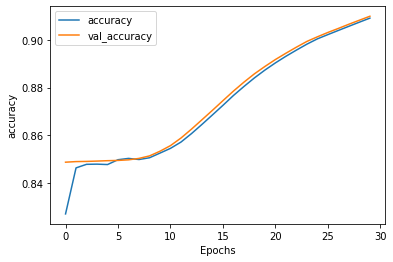

In [246]:
plot_graphs(history, 'accuracy')

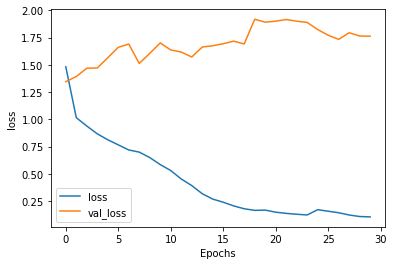

In [247]:
plot_graphs(history, 'loss')

In [248]:
SAVE_FILE_NAME = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NAME))